In [1]:
import json
import sklearn.metrics as sm
import numpy as np
import argparse

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D

## Closed-Set Performance vs Open-Set Uncertainty

In [2]:
with open('detector_results_processed.json', 'r') as f:
    all_results = json.load(f)

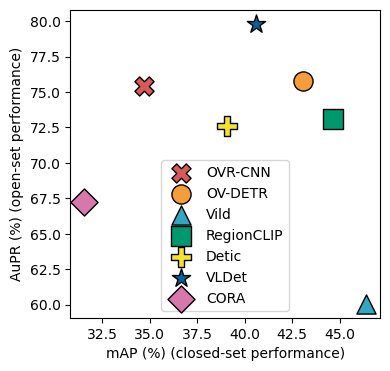

In [3]:
markerTypes = ['X', 'o', '^', 's', 'P', '*', 'D']
cols = ['#D85959', '#F59D3B', '#32A7BF', '#00986F', '#F5E22E', '#036398', '#D678AC', '#545154']

modelNames = ['OVR-CNN', 'OV-DETR', 'Vild', 'RegionCLIP', 'Detic', 'VLDet', 'CORA']
fig, ax = plt.subplots(1, figsize = (4, 4))
for mIdx, detector in enumerate(['ovrcnn', 'ovdetr', 'vild', 'regionclip', 'detic', 'vldet', 'cora']):              
    aupr = all_results[detector]['words']['aupr']['0']
    map = all_results[detector]['words']['map']['0']

    ax.scatter(100.*map, 100.*aupr, marker = markerTypes[mIdx], c = cols[mIdx], alpha = 1, s = 190, edgecolors = 'black', label = modelNames[mIdx])    


ax.set_xlabel('mAP (%) (closed-set performance)')
ax.set_ylabel('AuPR (%) (open-set performance)')
ax.legend(loc=8)
plt.savefig('../figures/detector_mapvsaupr.pdf', transparent = True, bbox_inches = 'tight')
plt.show()
        

## The influence of negative embeddings on performance

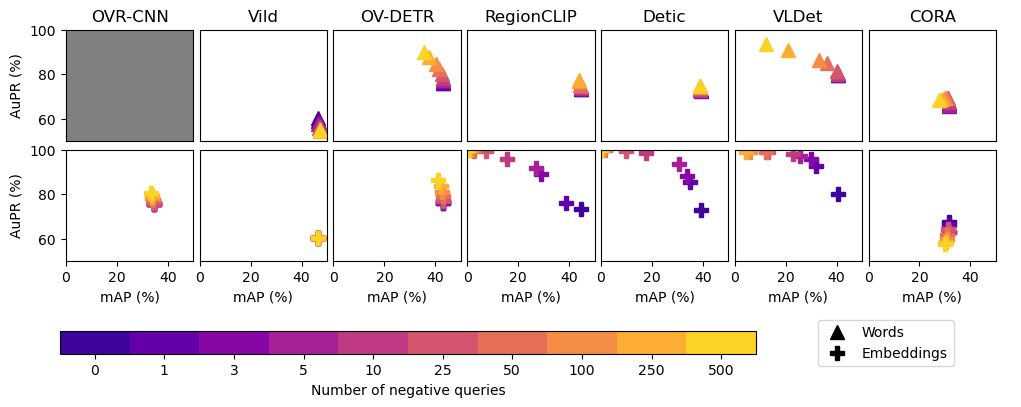

In [6]:
with open('detector_results_processed.json', 'r') as f:
    all_results = json.load(f)

cols = sns.color_palette("plasma", n_colors = 10)

markerTypes = ['^', 'P']
modelNames = ['OVR-CNN', 'Vild', 'OV-DETR', 'RegionCLIP', 'Detic', 'VLDet', 'CORA']

fig, ax = plt.subplots(2, 7, figsize = (12, 3))
for mIdx, modelType in enumerate(['ovrcnn', 'vild', 'ovdetr', 'regionclip', 'detic', 'vldet', 'cora']):
    lbls = ['Rand-Words', 'Rand-Embs']
    for tIdx, typ in enumerate(['words', 'embs']):
        
        aupr = all_results[modelType][typ]['aupr']
        map = all_results[modelType][typ]['map']
        
        ose = all_results[modelType][typ]['ose']
        num_neg = all_results[modelType][typ]['num_neg']

        prec_95rec = all_results[modelType][typ]['95rec']
        rec_95prec = all_results[modelType][typ]['95prec']

        if tIdx != 0 or mIdx != 0:
            #OVR-CNN doesn't have data for random words    
            for nIdx, n in enumerate(num_neg):
                ax[tIdx][mIdx].plot(100.*map[f'{n}'], 100.*aupr[f'{n}'], c = cols[nIdx], marker = markerTypes[tIdx], markersize = 10)
    
        if tIdx == 1:
            ax[tIdx][mIdx].set_xlabel('mAP (%)')

        if mIdx == 0:
            ax[tIdx][mIdx].set_ylabel('AuPR (%)')

        ax[tIdx][mIdx].set_xlim(0, 50)

        ax[tIdx][mIdx].set_ylim(50, 100)
        if tIdx == 0:
            ax[tIdx][mIdx].title.set_text(modelNames[mIdx])

        if mIdx != 0:
            ax[tIdx][mIdx].set_yticks([])
        if tIdx == 0:
            ax[tIdx][mIdx].set_xticks([])

ax[0,0].set_facecolor('grey') 
cmap = mpl.colors.ListedColormap(cols)
cmap.set_over('0.25')
cmap.set_under('0.75')

cax = fig.add_axes([0.12, -0.2, 0.58, 0.075])

bounds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb2 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                boundaries=bounds,
                                ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5],
                                orientation='horizontal')

cb2.minorticks_off()
cb2.set_ticklabels(['0', '1', '3', '5', '10', '25', '50', '100', '250', '500'])

cb2.set_label('Number of negative queries')


legend_elements = [Line2D([0], [0], color='k', marker = '^', markersize = 10, lw = 0, label='Words'),
                   Line2D([0], [0], color='k', marker = 'P', markersize = 10, lw = 0, label='Embeddings')]

fig.legend(handles = legend_elements, loc = (0.8, 0.1), ncols = 1)

plt.subplots_adjust(wspace = 0.05, hspace = 0.08)
plt.savefig('../figures/negpoints_vs_performance_detection_words+embs.pdf', bbox_inches= 'tight')
plt.show()